In [305]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [306]:
df = pd.read_csv('cleaned_merged_seasons.csv', skiprows=range(1,20035))

df['team_score'] = df.apply(lambda row: row['team_h_score'] if row['was_home'] else row['team_a_score'], axis=1)
df['opp_team_score'] = df.apply(lambda row: row['team_a_score'] if row['was_home'] else row['team_h_score'], axis=1)
df = df.drop(['team_a_score', 'team_h_score'], axis=1)


def pos_to_num(column):
    return column.map({'GK': 0, 'GKP': 0, 'DEF': 1, 'MID': 2, 'FWD': 3})

df['position'] = pos_to_num(df['position'])

def BoolToFloat(column):
    return column.map({True: 1, False: 0})

df['was_home'] = BoolToFloat(df['was_home'])

pl_teams = [
    "Arsenal", "Aston Villa", "Bournemouth", "Brentford", "Brighton", 
    "Burnley", "Chelsea", "Crystal Palace", "Everton", "Fulham", "Leeds", 
    "Leicester", "Liverpool", "Luton", "Man City", "Man Utd", 
    "Newcastle", "Norwich", "Nott'm Forest", "Sheffield Utd", 
    "Southampton", "Spurs", "Watford", "West Brom", 
    "West Ham", "Wolves", "Ipswich"
]
team_id = {team1: index for index, team1 in enumerate(pl_teams)}


df['team'] = df['team'].map(team_id)
df['opponent_team'] = df['opponent_team'].map(team_id)


df['match_no'] = df.groupby(['season_x', 'element']).cumcount() + 1

df = df.sort_values(by=['season_x','team', 'name', 'match_no'])

columns_to_shift = [
    'goals_scored', 'assists', 'goals_conceded', 'clean_sheets', 'bonus', 'bps', 
    'influence', 'creativity', 'threat', 'ict_index', 'minutes', 
    'opponent_team', 'own_goals', 'penalties_missed', 'penalties_saved', 
    'yellow_cards', 'red_cards', 'saves', 'selected', 'opp_team_score', 
    'team_score', 'total_points', 'value', 'was_home'
]

# Dictionary to hold all new columns
new_columns = {}

# Generate shifted columns for the last 5 matches
for i in range(1, 6):  # For each of the last 5 matches
    for col in columns_to_shift:
        new_columns[f'last_{i}_{col}'] = df.groupby(['element', 'team'])[col].shift(i)

# Concatenate the new columns into the original DataFrame at once
df = pd.concat([df, pd.DataFrame(new_columns)], axis=1)

# Create a list of all new columns
shifted_columns = list(new_columns.keys())

df['value change'] = df['value'] - df['last_1_value'] 
df['2-1 value change'] =  df['last_1_value'] - df['last_2_value'] 
df['3-2 value change'] =  df['last_2_value'] - df['last_3_value'] 
df['4-3 value change'] =  df['last_3_value'] - df['last_4_value'] 
df['5-4 value change'] =  df['last_4_value'] - df['last_5_value'] 
df['value_change_class'] = df['value change'].apply(
    lambda x: 'positive change' if x > 0 else 'negative change' if x < 0 else 'no change')


In [307]:
df = df.dropna(subset=shifted_columns)
df = df.drop([
    'name', 'season_x', 'assists', 'bonus', 'bps', 'clean_sheets',
    'creativity', 'element', 'fixture', 'goals_conceded', 'goals_scored',
    'ict_index', 'influence', 'minutes', 'opponent_team', 'own_goals',
    'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves',
    'selected', 'threat', 'transfers_balance', 'transfers_in', 'transfers_out',
    'GW', 'team_score', 'opp_team_score','opponent_team', 'match_no', 'total_points', 'yellow_cards',
    'kickoff_time', 'opponent_team_id', 'total_points', 'was_home', 'value', 'value change'], axis=1)



df.to_csv('output.csv', index=False)

In [308]:


# Prepare feature matrix and target vector
X = df.drop('value_change_class', axis=1)
y = df['value_change_class']

X.to_csv('X.csv', index=False)

In [302]:
#OVERSAMPLING

classes = y.unique()
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = {classes[i]: class_weights[i] for i in range(len(classes))}

# Oversample minority classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

from collections import Counter
print("Class distribution in y_resampled:", Counter(y_resampled))

Class distribution in y_resampled: Counter({'no change': 85636, 'negative change': 85636, 'positive change': 85636})


In [294]:

# UNDERSAMPLING
classes = y.unique()
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = {classes[i]: class_weights[i] for i in range(len(classes))}

# Undersample majority classes
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Split the undersampled data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Check class distributions after undersampling
from collections import Counter
print("Class distribution in y_resampled:", Counter(y_resampled))

Class distribution in y_resampled: Counter({'negative change': 2087, 'no change': 2087, 'positive change': 2087})


Classification Report:
                 precision    recall  f1-score   support

negative change       0.99      0.96      0.97     17176
      no change       0.96      0.97      0.97     16951
positive change       0.98      0.99      0.99     17255

       accuracy                           0.97     51382
      macro avg       0.97      0.97      0.97     51382
   weighted avg       0.97      0.97      0.97     51382



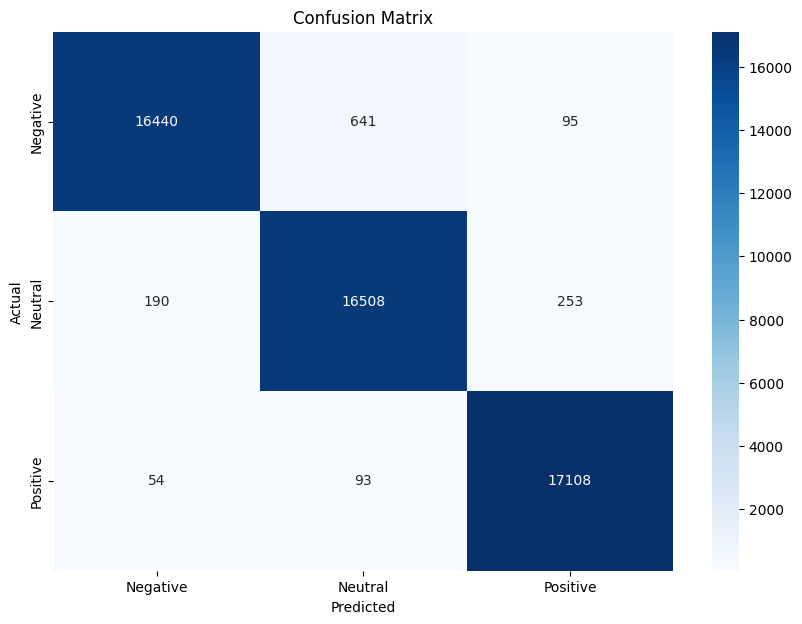

In [303]:
# Train classifier
model = RandomForestClassifier(class_weight=class_weights, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 7))  # Adjust the figure size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])

# Add labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Cross-validation
#scores = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='f1_macro')
#print("Cross-validation F1 Macro Score:", scores.mean())

In [296]:
df = pd.read_csv('new_season.csv')

df['team_score'] = df.apply(lambda row: row['team_h_score'] if row['was_home'] else row['team_a_score'], axis=1)
df['opp_team_score'] = df.apply(lambda row: row['team_a_score'] if row['was_home'] else row['team_h_score'], axis=1)
df = df.drop(['team_a_score', 'team_h_score'], axis=1)

def pos_to_num(column):
    return column.map({'GK': 0, 'DEF': 1, 'MID': 2, 'FWD': 3})

df['position'] = pos_to_num(df['position'])

def BoolToFloat(column):
    return column.map({True: 1, False: 0})

df['was_home'] = BoolToFloat(df['was_home'])

pl_teams = [
    "Arsenal", "Aston Villa", "Bournemouth", "Brentford", "Brighton", 
    "Burnley", "Chelsea", "Crystal Palace", "Everton", "Fulham", "Leeds", 
    "Leicester", "Liverpool", "Luton", "Man City", "Man Utd", 
    "Newcastle", "Norwich", "Nott'm Forest", "Sheffield Utd", 
    "Southampton", "Spurs", "Watford", "West Brom", 
    "West Ham", "Wolves", "Ipswich"
]
team_id = {team: index for index, team in enumerate(pl_teams)}


df['team'] = df['team'].map(team_id)
df['opponent_team'] = df['opponent_team'].map(team_id)


df['match_no'] = df.groupby(['element']).cumcount() + 1

df = df.sort_values(by=['team', 'name', 'match_no'])

columns_to_shift = [
    'goals_scored', 'assists', 'goals_conceded', 'clean_sheets', 'bonus', 'bps', 
    'influence', 'creativity', 'threat', 'ict_index', 'minutes', 
    'opponent_team', 'own_goals', 'penalties_missed', 'penalties_saved', 
    'yellow_cards', 'red_cards', 'saves', 'selected', 'opp_team_score', 
    'team_score', 'total_points', 'value', 'was_home'
]

# Dictionary to hold all new columns
new_columns = {}

# Generate shifted columns for the last 5 matches
for i in range(1, 6):  # For each of the last 5 matches
    for col in columns_to_shift:
        new_columns[f'last_{i}_{col}'] = df.groupby(['element', 'team'])[col].shift(i)

# Concatenate the new columns into the original DataFrame at once
df = pd.concat([df, pd.DataFrame(new_columns)], axis=1)

# Create a list of all new columns
shifted_columns = list(new_columns.keys())

df['value change'] = df['value'] - df['last_1_value'] 
df['2-1 value change'] =  df['last_1_value'] - df['last_2_value'] 
df['3-2 value change'] =  df['last_2_value'] - df['last_3_value'] 
df['4-3 value change'] =  df['last_3_value'] - df['last_4_value'] 
df['5-4 value change'] =  df['last_4_value'] - df['last_5_value'] 
df['value_change_class'] = df['value change'].apply(
    lambda x: 'positive change' if x > 0 else 'negative change' if x < 0 else 'no change')

df = df.dropna(subset=shifted_columns)
df = df.drop([
    'name', 'assists', 'bonus', 'bps', 'clean_sheets',
    'creativity', 'element', 'fixture', 'goals_conceded', 'goals_scored',
    'ict_index', 'influence', 'minutes', 'opponent_team', 'own_goals',
    'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves',
    'selected', 'threat', 'transfers_balance', 'transfers_in', 'transfers_out',
    'GW', 'team_score', 'opp_team_score', 'match_no', 'total_points', 'yellow_cards',
    'kickoff_time', 'opponent_team', 'total_points', 'was_home', 'value', 'value change',
    'xP', 'expected_assists', 'expected_goal_involvements', 'expected_goals',
    'expected_goals_conceded', 'starts'], axis=1)

# Prepare feature matrix and target vector
x_unseen = df.drop('value_change_class', axis=1)
y_unseen = df['value_change_class']
df.to_csv('output1.csv', index=False)




Classification Report:
                 precision    recall  f1-score   support

negative change       0.20      0.67      0.31       418
      no change       0.96      0.64      0.77      4611
positive change       0.20      0.96      0.33       141

       accuracy                           0.66      5170
      macro avg       0.45      0.76      0.47      5170
   weighted avg       0.88      0.66      0.72      5170



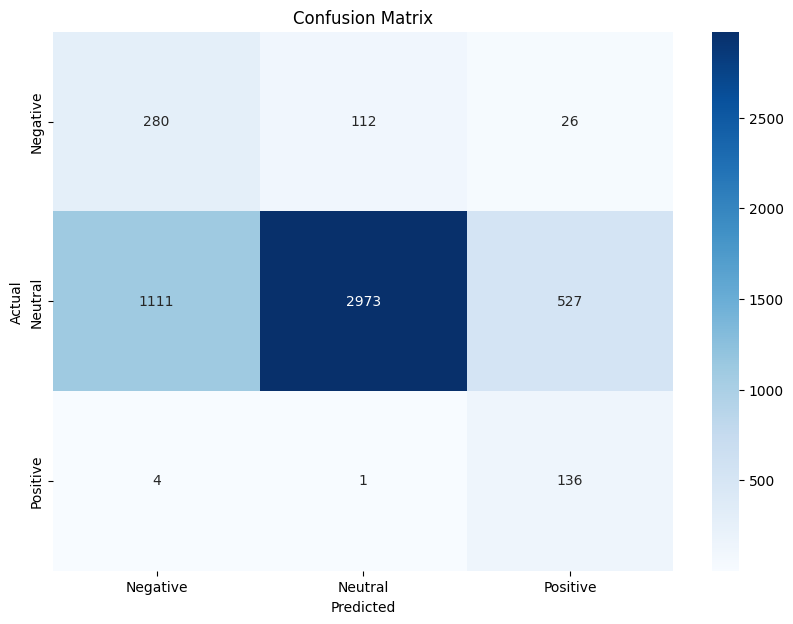

In [297]:
y_pred_unseen = model.predict(x_unseen)
df['result'] = y_pred_unseen
print("Classification Report:")
print(classification_report(y_unseen, y_pred_unseen))
cm = confusion_matrix(y_unseen, y_pred_unseen)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 7))  # Adjust the figure size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])

# Add labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()